In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import sys
sys.path.append("..") 

In [6]:
pb_map = np.load('data/exports_for_shp/pb_5m.npy')
segmentation_map = np.load('data/exports_for_shp/segmentation_5m.npy')
smooth_map = np.load('data/exports_for_shp/smooth_5m.npy')
postproc_map = np.load('data/exports_for_shp/postproc_5m.npy')

### Export the data as XY file

In [7]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-7-c54fc2603a60>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using P

In [8]:
filenameraster='../../../Maupiti/Data/New_classification/downsampled_image_pleiades_2.tif'

adr=filenameraster[:-4]

src = rio.open(filenameraster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

raster_array_original = src.read()

img_final = raster_array_original[:,300:2100,500:2000]

In [9]:
src.crs

CRS.from_epsg(32731)

In [10]:
with rio.open(filenameraster) as src:
    src_crs = src.crs  # Original CRS
    src_transform = src.transform  # Original transform
    src_bounds = src.bounds  # Original bounds
    
    # Define the target CRS
    target_crs = 'EPSG:32705'

    # Calculate the transform and dimensions of the target CRS
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the target raster
    profile = src.profile
    profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create a new raster file with the target CRS
    target_raster = 'reprojected_image.tif'
    with rio.open(target_raster, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

In [13]:
src = rio.open(target_raster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

In [10]:
raster_array = src.read()

img_final = raster_array[:,300:2100,500:2000]

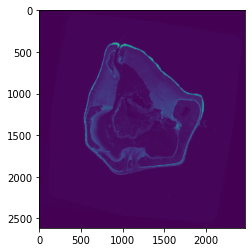

In [11]:
plt.imshow(raster_array[0])

In [12]:
row_start = 300
row_end = 2100
col_start = 500
col_end = 2000

x = np.arange(X0 + col_start * dx, X0 + col_end * dx, dx)
y = np.arange(Y0 + row_start * dy, Y0 + row_end * dy, dy)

In [25]:
map_to_export = 5*np.ones(src.shape)
#map_to_export[300:2100,500:2000] = np.flip(pb_map)
map_to_export[300:2100,500:2000] = np.flip(segmentation_map)
#map_to_export[300:2100,500:2000] = np.flip(smooth_map)
#map_to_export[300:2100,500:2000] = np.flip(postproc_map)

x = np.arange(X0, XF, dx)
y = np.arange(Y0, YF, dy)

In [28]:
x_flat = np.tile(x, len(y))  # Repeat x for each row in y
y_flat = np.repeat(y, len(x))  # Repeat each element in y for every column in x
#img_rugo_flat = predicted_map_pixelbased_rf_classes.flatten()
img_rugo_flat = np.fliplr(np.flip(map_to_export)).flatten()

In [29]:
original_dict = {
    'BackReefSlope': 1, 'InnerReef': 2, 'Lagoon': 3, 'Land': 4,
    'Ocean': 5, 'OuterReefFlat': 6, 'PatchReef': 7, 'ReefCrest': 8,
    'ReefFront': 9, 'ShallowLagoon': 10, 'ShoreReef': 11, 'Unspecified': 12
}
original_dict = {'Boundaries': 1, 'Interior of segment': 0}
reverse_dict = {v: k for k, v in original_dict.items()}

rugo_flat_strings = np.vectorize(reverse_dict.get)(img_rugo_flat)

In [30]:
# Create a dataframe
data_to_export = pd.DataFrame({'X': x_flat, 'Y': y_flat, 'Value': rugo_flat_strings})

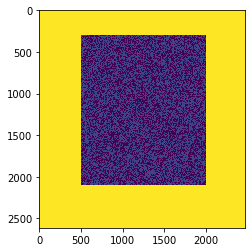

In [31]:
plt.imshow(map_to_export, interpolation='None')

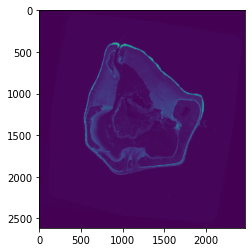

In [32]:
plt.imshow(raster_array_original[0])
plt.show()

In [33]:
gdf = gpd.GeoDataFrame(data_to_export, geometry=gpd.points_from_xy(data_to_export.X, data_to_export.Y))
#gdf.set_crs(epsg=32705, inplace=True) 
gdf.set_crs(epsg=32731, inplace=True) 

# Save to a shapefile
output_shapefile = 'outputs shp/output_segmentation_5m.shp'
#output_shapefile = 'outputs shp/output_pb_5m.shp'
gdf.to_file(output_shapefile)